In [1]:
!pip install pypdf
!pip install langchain tiktoken
!pip install langchain langgraph cassio
!pip install -U langchain_community tiktoken langchain-groq langchainhub langchain langgraph langchain_huggingface



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import cassio

ASTRA_DB_APPLICATION_TOKEN= "AstraCS:AebMyTuHchRGfMpZRslkPGIk:c7790bbd39d9b1f58824398de28bfcadc35c48cf8c519cac6f590dbd85b98190"
ASTRA_DB_ID= "e4db7fab-b615-4eda-8da9-ed82b6741c3d"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [3]:
import os
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader


def load_multiple_pdfs(directory):
    # Create a loader for the directory containing PDF files
    loader = DirectoryLoader(directory, glob="*.pdf", loader_cls=PyPDFLoader)

    # Load all PDF files from the directory
    documents = loader.load()

    return documents

# Specify the directory containing your PDF files
pdf_directory = "pdf_files"  

# Load the PDF files
pdf_documents = load_multiple_pdfs(pdf_directory)






In [4]:
pdf_documents[:100]

[Document(metadata={'source': 'pdf_files\\disease -- Britannica Online Encyclopedia.pdf', 'page': 0}, page_content='TABLE OF CONTENTS\nIntroduction\nMajor distinctions\nControl of disease\nAn image, produced by magnetic resonance imaging (MRI), of a human brain af fected by cancer . The bright\nblue area indicates that the cancer spread to the occipital lobe (lower right).disease\ndisease , any harmful deviation from the normal structural or functional\nstate of an or ganism, generally associated with certain signs and\nsymptoms and dif fering in nature from physical injury . A diseased\norganism commonly exhibits signs or symptoms indicative of its\nabnormal state. Thus, the normal condition of an or ganism must be\nunderstood in order to recognize the hallmarks of disease.\nNevertheless, a sharp demarcation between disease and health  is not\nalways apparent.\nThe study of disease is called pathology . It involves the determination of the cause (etiology) of the disease,\nthe underst

In [5]:
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=600, 
    chunk_overlap=0
)

# Step 1: Split documents into chunks and create Document instances
doc_splits = text_splitter.split_documents(pdf_documents)
        

In [6]:
doc_splits[8]

Document(metadata={'source': 'pdf_files\\disease -- Britannica Online Encyclopedia.pdf', 'page': 4}, page_content='Colourized scanning electron\nmicrograph of the bacterium Rickettsia\nprowazekii , which causes epidemic\ntyphus and typically is transmitted to\nhumans by certain arthropods,\nparticularly the body louse.protective protein  coat. Viruses are obligatory intracellular\nparasites, capable of multiplying only within the cells of the host,\nand they have no independent metabolic activity of their own.\nThe genetic information that directs the synthesis of virus\nmaterials and certain enzymes enters the host cell, parasitizes its\nchemical processes, and directs them toward the synthesis of new virus elements.\nThese various degrees of parasitism suggest that the host-parasite relationship is subject to continuing\nevolutionary change. The adaptation of the microor ganism to its parasitic existence, in this view , is\naccompanied by progressive loss in metabolic capability , wi

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\D\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
C:\Users\D\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="DoctorAI",
    session=None,
    keyspace=None
)

In [9]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 1089 headlines.


In [10]:
retriever=astra_vector_store.as_retriever()

In [11]:
retriever.invoke("What is health")

[Document(metadata={'page': '1.0', 'source': 'pdf_files\\human disease -- Britannica Online Encyclopedia.pdf'}, page_content='the unusual illustrates the concept of physical fitness. To be in good physical condition is to have the ability to\nswim a mile to save one’ s life or to slog home through snowdrifts when a car breaks down in a storm. Some\nexperts in fitness insist that the state of health requires that the individual be in prime physical condition. They\nprefer to divide the spectrum of health and disease into (1) health, (2) absence of disease, and (3) disease. In\ntheir view , those who are not in prime condition and are not physically fit cannot be considered as healthy\nmerely because they have no disease.\nHealth involves more than physical fitness, since it also implies mental and emotional well-being. Should the\nangry , frustrated, emotionally unstable person in excellent physical condition be called healthy? Certainly this\nindividual could not be characterized as ef

In [29]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question, choose to route it to Wikipedia or a vectorstore.",
    )

# LLM with function call
from langchain_groq import ChatGroq
import os

llm = ChatGroq(
    model_name="llama-3.1-70b-versatile",
    temperature=0,
    groq_api_key="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",
)

structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = system = """  You are a highly knowledgeable and concise medical assistant responsible for routing user questions to either a vectorstore or Wikipedia.
The vectorstore contains medical documents covering topics such as diseases, treatments, symptoms, and medications. 
Use the vectorstore for questions related to these topics. For all other general medical questions or those requiring external information, route the query to Wikipedia.
Always provide relevant, accurate, and clear responses, avoiding unnecessary details or unrelated information.
 """

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router




In [30]:
# User question
user_question = "What are the symptoms of diabetes?"

# Pass the question to the question_router using .invoke()
response = question_router.invoke(user_question)

# Output
print(response.datasource)  # Expected output: 'vectorstore' or 'wiki_search'


wiki_search


In [31]:
### Working With Tools
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun



api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [32]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [33]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
   
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [34]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

   
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [35]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        return "wiki_search"
    elif source.datasource == "vectorstore":
        return "vectorstore"

In [36]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

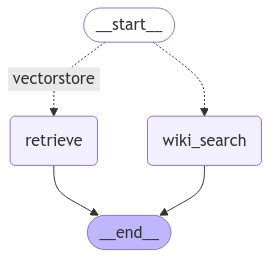

In [37]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
from pprint import pprint

# Run
inputs = {
    "question": " What is the treatment for diabetes in 2 lines ?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].page_content)

---ROUTE QUESTION---
"Node 'retrieve':"
'\n---\n'
('STG ENDOCRINE CONDITIONS  \n'
 'Ministry of Health, Nauru 2014  111 7.1.5 Dietary Advice  \n'
 'All new type 1 diabetics must be advised on appropriate food intake by \n'
 'a dietician  (or a trained member  of the diabetes  clinic staff).  \n'
 '7.2 DIABETES MELLITUS TYPE 2  \n'
 '7.2.1 Description  \n'
 '\uf0b7 Type 2 diabetes  mellitus is the most prevalent form (up to 80% of \n'
 'all diabetics) and is a metabolic disorder characteri sed by chronic \n'
 'hyperglycaemia  due to insulin  resistance and rela tive insulin \n'
 'deficiency or  both \n'
 '\uf0b7 Its late complications  result  in reduced  life expectancy and   \n'
 'considerable use of health resources  \n'
 '\uf0b7 Macrovascular disease  leads to an increased prevalence of coronary \n'
 'artery disease, peripheral vascular disease and stroke ; and \n'
 'microvascular disease  lead to diabetic retinopathy, neuropathy and \n'
 'nephropathy  \n'
 '\uf0b7 Patients ar e pro

In [49]:
from pprint import pprint
from langchain.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain.schema import HumanMessage

# Initialize LLM
llm = ChatGroq(
    model_name="llama-3.1-70b-versatile",
    temperature=0,
    groq_api_key="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"
)

# Define a template to make the response user-friendly
prompt_template = """
You are a helpful medical assistant. Based on the content provided, give a clear and concise answer to the user’s question. 
Format the answer to be friendly and easy to understand. 

Question: {question}

Document Content:
{document_content}

Answer:
"""

# Run the process
inputs = {
    "question": "What is the treatment for diabetes?"
}



for output in app.stream(inputs):
    for key, value in output.items():
        # Node (optional to print node details)
        pprint(f"Node '{key}':")
        
    # Extract the retrieved content (assuming 'documents' contains the pages)
    document_content = value['documents'][0].page_content if value['documents'] else "No content found."
    
    # Build the LLM prompt
    prompt = prompt_template.format(
        question=inputs["question"],
        document_content=document_content
    )
    
    # Pass the prompt to the LLM as a HumanMessage
    response = llm([HumanMessage(content=prompt)])
    
    # Print final user-friendly answer
    pprint(response)
    pprint("\n---\n")


---ROUTE QUESTION---
"Node 'retrieve':"
AIMessage(content="Don't worry, I'm here to help.  If you or someone you know has diabetes, there are several treatment options available. The main goal of treatment is to manage blood sugar levels and prevent complications.\n\nHere are some general treatment options for diabetes:\n\n1. **Adjusting insulin dosage**: If you're taking insulin, your doctor may adjust the dosage based on your blood glucose levels and physical activity.\n2. **Adjusting oral antidiabetic medications**: If you're taking oral medications, your doctor may adjust the dosage and take into account any potential interactions with other medications.\n3. **Eating a balanced diet**: It's essential to eat regular meals and increase your carbohydrate intake if necessary. Avoid missing meals to prevent low blood sugar levels.\n4. **Monitoring blood glucose levels**: Regularly checking your blood glucose levels will help you and your doctor adjust your treatment plan as needed.\n\nR

In [48]:
from pprint import pprint

# Run
inputs = {
    "question": "who is imran khan"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'].page_content)

---ROUTE QUESTION---
who is imran khan
"Node 'wiki_search':"
'\n---\n'
('Page: Family of Imran Khan\n'
 'Summary: The family of Imran Khan, the former Prime Minister of Pakistan and '
 'former captain of the Pakistan cricket team, is a prominent Pakistani family '
 'active in politics ')


In [15]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import os

cloud_config = {
    'secure_connect_bundle': 'D:/PycharmProjects/PycharmProjects/AI_Projects/DocAi/secure-connect-doctorai.zip'  # Make sure this path is correct
}

# Use the new client_id and client_secret
auth_provider = PlainTextAuthProvider("qjTApUQIQKJPreiBosBnQRED", "rWUkkyUI.i-.trJdZvGimkGuo6J6wGknEYYZbZZqmgC72BP6+y62WM1xkcOzZawqM+jv9D7KcKrydiX.qt5pOK_GAgMTLSPOdWSb,ENFmtQtUYHZGjlyitX_0WUEh,Ii")

try:
    cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
    session = cluster.connect()

    # Run a simple query to test the connection
    print("Connected successfully, running test query...")
    rows = session.execute("SELECT * FROM system.local")
    for row in rows:
        print(row)

except Exception as e:
    print(f"Error occurred: {e}")


Connected successfully, running test query...
Row(key='local', rpc_address='10.0.0.2', broadcast_address='10.0.0.2', listen_address='10.0.0.2', rpc_port=29042, broadcast_port=29042, listen_port=29042, data_center='us-east-2', rack='rack2', tokens=SortedSet(['-5124095576030431007', '-7173733806442603407']), release_version='4.0.11-7cde36df13c4', partitioner='org.apache.cassandra.dht.Murmur3Partitioner', cluster_name='cndb', cql_version='3.4.5', schema_version=UUID('d8fd2d5d-76e3-39fd-91df-ee82dc75dfa0'), native_protocol_version='ProtocolVersion OSS 4', host_id=UUID('98a2cd7e-fa1b-3950-942e-42af495c4248'))


In [20]:
keyspaces = session.execute("SELECT keyspace_name FROM system_schema.keyspaces")
for keyspace in keyspaces:
    print(keyspace)


Row(keyspace_name='datastax_sla')
Row(keyspace_name='data_endpoint_auth')
Row(keyspace_name='system_auth')
Row(keyspace_name='system_schema')
Row(keyspace_name='default_keyspace')
Row(keyspace_name='system')
Row(keyspace_name='system_traces')


In [21]:
from langchain.vectorstores.cassandra import Cassandra

# Ensure the embeddings object is properly defined
astra_vector_store = Cassandra(
    embedding=embeddings,  # The embeddings model you're using
    table_name="DoctorAI",  # The name of your table in AstraDB
    session=session,  # Pass the session object that is connected to Cassandra
    keyspace="default_keyspace"  # Use the correct keyspace from the list
)


In [22]:
retriever=astra_vector_store.as_retriever()

In [23]:
retriever.invoke("What is health")

[Document(metadata={'page': '1.0', 'source': 'pdf_files\\human disease -- Britannica Online Encyclopedia.pdf'}, page_content='the unusual illustrates the concept of physical fitness. To be in good physical condition is to have the ability to\nswim a mile to save one’ s life or to slog home through snowdrifts when a car breaks down in a storm. Some\nexperts in fitness insist that the state of health requires that the individual be in prime physical condition. They\nprefer to divide the spectrum of health and disease into (1) health, (2) absence of disease, and (3) disease. In\ntheir view , those who are not in prime condition and are not physically fit cannot be considered as healthy\nmerely because they have no disease.\nHealth involves more than physical fitness, since it also implies mental and emotional well-being. Should the\nangry , frustrated, emotionally unstable person in excellent physical condition be called healthy? Certainly this\nindividual could not be characterized as ef

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\D\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
C:\Users\D\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
{
  "clientId": "qjTApUQIQKJPreiBosBnQRED",
  "secret": "rWUkkyUI.i-.trJdZvGimkGuo6J6wGknEYYZbZZqmgC72BP6+y62WM1xkcOzZawqM+jv9D7KcKrydiX.qt5pOK_GAgMTLSPOdWSb,ENFmtQtUYHZGjlyitX_0WUEh,Ii",
  "token": "AstraCS:qjTApUQIQKJPreiBosBnQRED:a6f364dbc5a5e9bd1a8d370a2244b9031e8bab6d37f31bbfd5c2ad863f1b5958"
}

In [ ]:
ASTRA_DB_APPLICATION_TOKEN= "AstraCS:AebMyTuHchRGfMpZRslkPGIk:c7790bbd39d9b1f58824398de28bfcadc35c48cf8c519cac6f590dbd85b98190"
ASTRA_DB_ID = "e4db7fab-b615-4eda-8da9-ed82b6741c3d"
ASTRA_DB_KEYSPACE="default_keyspace"